In [118]:
import matplotlib.pyplot as plt
import numpy as np
from os import sep

from settings import DIR_DATA, DIR_OUTPUT, DIR_MODELS
from plotting import image_fancy

plt.rc('text', usetex=True)

In [119]:
from data_process import data_mnist, binarize_image_data, image_data_collapse
from settings import MNIST_BINARIZATION_CUTOFF


TRAINING, TESTING = data_mnist(binarize=True)
num_features = TRAINING[0][0].shape[0] ** 2
num_samples = len(TRAINING)

Processing MNIST data: numpy_binarize = True


In [120]:
NOTEBOOK_OUTDIR = DIR_OUTPUT + sep + 'ICLR_nb_reversemap'
bigruns = DIR_OUTPUT + sep + 'archive' + sep + 'big_runs'

In [121]:
"""
# SAVE (transposed version)
fpath = DIR_MODELS + sep + 'pca_binarized_raw.npz'
np.savez(fpath, pca_weights=pca_weights.T)

# LOAD
with open(fpath, 'rb') as f:
    pca_weights = np.load(fpath)['pca_weights']
    print(pca_weights)

from RBM_train import load_rbm_hopfield

k_pattern = 12
fname = 'hopfield_mnist_%d0_PCA.npz' % k_pattern
rbm = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)

rbm_weights = rbm.internal_weights
print(rbm_weights.shape)
for idx in range(2):
    plt.imshow(rbm_weights[:, idx].reshape(28,28))
    plt.show()
"""

"\n# SAVE (transposed version)\nfpath = DIR_MODELS + sep + 'pca_binarized_raw.npz'\nnp.savez(fpath, pca_weights=pca_weights.T)\n\n# LOAD\nwith open(fpath, 'rb') as f:\n    pca_weights = np.load(fpath)['pca_weights']\n    print(pca_weights)\n\nfrom RBM_train import load_rbm_hopfield\n\nk_pattern = 12\nfname = 'hopfield_mnist_%d0_PCA.npz' % k_pattern\nrbm = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)\n\nrbm_weights = rbm.internal_weights\nprint(rbm_weights.shape)\nfor idx in range(2):\n    plt.imshow(rbm_weights[:, idx].reshape(28,28))\n    plt.show()\n"

# Nov 16: Reverse map testing

In [137]:
import matplotlib as mpl
import os
from scipy.linalg import qr

from data_process import image_data_collapse


def rebuild_R_from_xi_image(xi_image):
    xi_collapsed = image_data_collapse(xi_image)
    Q, R = qr(xi_collapsed, mode='economic')
    return Q, R


def plot_basis_candidate(xcol, idx, outdir, label=''):
    cmap='seismic_r'
    norm = mpl.colors.DivergingNorm(vcenter=0.)

    plt.figure()
    plt.imshow(xcol.reshape((28, 28)), cmap=cmap, norm=norm)

    # turn off labels
    ax = plt.gca()
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)

    # colorbar
    plt.colorbar()

    #plt.title('Basis example: %d %s' % (idx, label))
    plt.savefig(outdir + os.sep + 'basis_example_%d%s.jpg' % (idx, label))
    plt.close()


def plot_basis_candidate_fancy(xcol, idx, outdir, label=''):

    # generate masked xnol for discrete cmap
    # ref: https://stackoverflow.com/questions/53360879/create-a-discrete-colorbar-in-matplotlib
    # v <= -1.5       = orange
    # -1.5 < v < -0.5 = light orange
    # -0.5 < v < 0.5  = grey
    # 0.5 < v < 1.5   = light blue
    # v > 1.5         = blue
    cmap = mpl.colors.ListedColormap(["firebrick", "salmon", "lightgrey", "deepskyblue",  "mediumblue"])
    norm = mpl.colors.BoundaryNorm(np.arange(-2.5, 3), cmap.N)

    # clip the extreme values
    xcol_clipped = xcol
    xcol_clipped[xcol_clipped > 1.5] = 2
    xcol_clipped[xcol_clipped < -1.5] = -2
    img = xcol_clipped.reshape((28, 28))

    # plot prepped image
    plt.figure()
    ims = plt.imshow(img, cmap=cmap, norm=norm)

    # turn off labels
    ax = plt.gca()
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)

    # colorbar
    plt.colorbar(ims, ticks=np.linspace(-2, 2, 5))

    #plt.title(r'$Basis example: %d %s$' % (idx, label))
    plt.savefig(outdir + os.sep + 'basis_example_%d%s.jpg' % (idx, label))
    plt.close()


def plot_error_timeseries(error_timeseries, outdir, label='', ylim=None):
    plt.plot(error_timeseries)
    plt.xlabel('iteration')
    #plt.ylabel(r'$||Wx - tanh(\beta Wx)||^2$')
    plt.title('Error over gradient updates %s' % (label))
    print('error_timeseries min/max', np.min(error_timeseries), np.max(error_timeseries))

    if ylim is None:
        plt.savefig(outdir + os.sep + 'error_%s.jpg' % (label))
    else:
        plt.ylim(ylim)
        plt.savefig(outdir + os.sep + 'error_%s_ylim.jpg' % (label))
    plt.close()


def binarize_search_as_matrix_NB(weights, outdir, num_steps=200, beta=100, noise=0, init=None):
    # search for (p x p) X such that W*X is approximately binary (N x p matrix)
    # condition for binary: W*X = sgn(W*X)
    # soften the problem as W*X = tanh(beta W*X)
    #    define error E = W*X - tanh(beta W*X)
    # perform gradient descent on ||W*X - tanh(beta W*X)||^2 = tr(E * E^T)

    # speedups and aliases
    N, p = weights.shape
    WTW = np.dot(weights.T, weights)

    def get_err(err_matrix):
        err = np.trace(
            np.dot(err_matrix, err_matrix.T)
        )
        return err

    def build_overlaps(X):
        overlaps = np.zeros((p, p))
        for i in range(p):
            x_i = X[:, i]
            for j in range(p):
                x_j = X[:,j]
                overlaps[i,j] = np.dot(X[:,i],
                                       np.dot(WTW, X[:,j]))
        return overlaps


    def gradient_search(X, num_steps=num_steps, eta=2*1e-2, noise=noise, plot_all=True):
        # note eta may need to be prop. to beta; 0.1 worked with beta 200
        # performs gradient descent for single basis vector
        # TODO idea for gradient feedback: add terms as basis formed corresponding to 'dot product with basis elements is small'

        err_timeseries = np.zeros(num_steps + 1)
        ALPHA = 1e-3  # lagrange mult for encouraging basis vector separation

        # large local output dir for gradient traj
        outdir_local = outdir + os.sep + 'num_details'
        if not os.path.exists(outdir_local):
            os.makedirs(outdir_local)

        def gradient_iterate(X, col_by_col=True):

            # gather terms
            WX = np.dot(weights, X)
            tanhu = np.tanh(beta * WX)
            err_matrix = WX - tanhu

            if col_by_col:
                for col in range(p):
                    delta = 1 - tanhu[:, col] ** 2
                    factor_2 = err_matrix[:, col] - beta * err_matrix[:, col] * delta
                    gradient = np.dot(2 * weights.T, factor_2)
                    
                    
                    print('grad:', np.mean(gradient), np.linalg.norm(gradient), np.min(gradient), np.max(gradient))
                    
                    # encourage separation of the near binary vectors (columns of W*X)
                    # TODO look into this lagrange mult problem further
                    
                    """
                    #overlaps = build_overlaps(X)
                    colsum = 0
                    for c in range(p):
                        if c != col:
                            colsum += X[:, c]  # TODO weight them by their magnitude?
                    alternate_obj = np.dot( WTW, colsum)
                    """
                    
                    # compute overall update (binarization gradient + separation gradient)
                    noise_vec = np.random.normal(loc=0, scale=noise, size=p)  # saw print(np.min(gradient * eta), np.max(gradient * eta)) in -1.5, 1.5
                    new_xcol = X[:, col] - gradient * eta + noise_vec      # - ALPHA * alternate_obj

                    #magA = np.linalg.norm(gradient)
                    #print('A', magA, eta * magA)
                    #magB = np.linalg.norm(alternate_obj)
                    #print('B', magB, ALPHA * magB)

                    # update X
                    X[:, col] = new_xcol
            else:
                # compute gradient
                delta = 1 - tanhu ** 2
                factor_2 = err_matrix - beta * err_matrix * delta
                gradient = np.dot(2 * weights.T, factor_2)
                X = X - gradient * eta

            return X, WX, err_matrix

        for idx in range(num_steps):
            X, WX, err_matrix = gradient_iterate(X, col_by_col=True)
            err_timeseries[idx] = get_err(err_matrix)

            if plot_all and idx % 10 == 0:
                for col in range(p):
                    candidate = WX[:, col]
                    plot_basis_candidate_fancy(candidate, col, outdir_local, '(iterate_%s_discrete)' % idx)
                    plot_basis_candidate(candidate, col, outdir_local, '(iterate_%s)' % idx)

        # compute last element of error (not done in loop)
        WX = np.dot(weights, X)
        tanhu = np.tanh(beta * WX)
        err_matrix = WX - tanhu
        err_timeseries[num_steps] = get_err(err_matrix)
        
        print('ZEROTH err_timeseries')
        print(err_timeseries[0], err_timeseries[1], err_timeseries[-1])
        
        return X, err_timeseries

    # initial guesses for candidate columns of R matrix
    if init is None:
        X = np.random.rand(p, p)*2 - 1  # draw from U(-1,1)
    else:
        assert init.shape == (p, p)
        X = init

    # perform num random searches for basis vector candidates
    x0 = X
    X_final, err_timeseries = gradient_search(x0)
    plot_error_timeseries(err_timeseries, outdir, 'traj')
    plot_error_timeseries(err_timeseries, outdir, 'traj', ylim=(-10, np.min(err_timeseries)*2))
    WX_final = np.dot(weights, X_final)
    for idx in range(p):
        candidate = WX_final[:, idx]
        plot_basis_candidate_fancy(candidate, idx, outdir, 'final_fancy')
        plot_basis_candidate(candidate, idx, outdir, 'final')
    return X_final

##############################################
# MAIN (load weights)
##############################################

# THINK PATH TOO LONG FOR PYTHON - CHANGE HKEY
run_num = 0
rundir = 'NOVEMBER_fig4_comparisons_alt_inits_p10_1000batch_earlysteps'
subdir = 'hopfield_10hidden_0fields_2.00beta_1000batch_3epochs_20cdk_1.00E-04eta_1000ais_10ppEpoch'
weights_fname = 'weights_10hidden_0fields_20cdk_1000stepsAIS_2.00beta.npz'
objective_fname = 'objective_10hidden_0fields_20cdk_1000stepsAIS_2.00beta.npz'
iteration_idx = 0

"""
run_num = 0
rundir = 'NOVEMBER_fig4_comparisons_alt_inits_p10_1000batch'
subdir = 'hopfield_10hidden_0fields_2.00beta_1000batch_70epochs_20cdk_1.00E-04eta_0ais_1ppEpoch'
weights_fname = 'weights_10hidden_0fields_20cdk_0stepsAIS_2.00beta.npz'
objective_fname = 'objective_10hidden_0fields_20cdk_0stepsAIS_2.00beta.npz'
iteration_idx = 0"""

weights_path = bigruns + sep + 'rbm' + sep + rundir + sep + subdir + sep + 'run%d' % run_num + sep + weights_fname
objective_path = bigruns + sep + 'rbm' + sep + rundir + sep + subdir + sep + 'run%d' % run_num + sep + objective_fname

weights_obj = np.load(weights_path)
weights_timeseries = weights_obj['weights']
objective_obj = np.load(objective_path)
epochs = objective_obj['epochs']
iterations = objective_obj['iterations']
print('weights_timeseries.shape', weights_timeseries.shape)
print('epochs', epochs)
print('iterations', iterations)


HIDDEN_UNITS = 10
from RBM_train import load_rbm_hopfield
fname = 'hopfield_mnist_%d.npz' % HIDDEN_UNITS
rbm = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)
Q, R_star = rebuild_R_from_xi_image(rbm.xi_image)
X_star = R_star
print(X_star)

weights_timeseries.shape (784, 10, 31)
epochs [0 1 2 3]
iterations [  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180.]
LOADING: models\saved\hopfield_mnist_10.npz
[[ 28.          13.57142857  16.28571429  17.42857143  15.42857143
   19.28571429  16.92857143  16.42857143  17.57142857  16.71428571]
 [  0.          24.49114792  12.86095665  13.04427987  13.0092818
   11.68852138  11.7697669   14.57836184  12.63846894  13.9300643 ]
 [  0.           0.          18.79817289   5.97937619   6.45929183
    1.89341808   7.81648628   3.24272472   6.98439866   4.92824307]
 [  0.           0.           0.          16.56317364   1.13400927
    7.73328534   0.88710888   2.1807274    3.8116505    3.47266788]
 [  0.           0.           0.           0.          18.26771312
    3.14160582   6.36123174   7.30567223   3.45110735  11.88607013]
 [  0.           0.           0.           0.           

Spectral dynamics of the weights

No handles with labels found to put in legend.


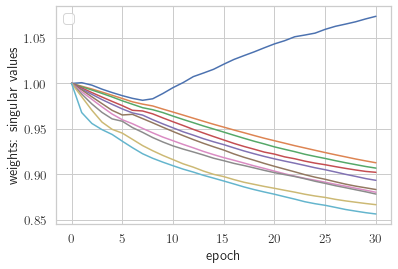

(array([[1.00000005, 1.00079617, 0.99810208, 0.99369214, 0.98995015,
         0.98654718, 0.98359803, 0.98146154, 0.98312243, 0.9889144 ,
         0.99537732, 1.00094483, 1.00746535, 1.01141416, 1.01554117,
         1.02110901, 1.02632545, 1.03058571, 1.03469854, 1.03917132,
         1.04345458, 1.04693814, 1.05128496, 1.05318959, 1.05527102,
         1.05943488, 1.06275634, 1.06518878, 1.06774595, 1.0709229 ,
         1.07376731],
        [1.00000001, 0.99695743, 0.99387379, 0.99046689, 0.98699135,
         0.98343364, 0.97978988, 0.9772587 , 0.9752276 , 0.97181262,
         0.96852107, 0.96519658, 0.96178236, 0.95842661, 0.95509457,
         0.95197256, 0.94881404, 0.9458229 , 0.9427283 , 0.93973338,
         0.93701389, 0.93431812, 0.93157037, 0.92904295, 0.92650592,
         0.92400146, 0.92159836, 0.91928978, 0.916941  , 0.9148165 ,
         0.91279634],
        [1.00000001, 0.99632186, 0.99278275, 0.98902823, 0.98511286,
         0.98089057, 0.97712593, 0.97332969, 0.97110809, 0.

In [128]:
# SHORT VERION: note epoch label is not correct if ppEpoch not 1
from weights_analysis import plot_weights_timeseries
plot_weights_timeseries(weights_timeseries, NOTEBOOK_OUTDIR, mode='eval', extra=False)  # use eval or minmax

Reverse map analysis

In [138]:
iteration_idx_pick = 0
noise = 0.0
X_guess = True
num_steps = 20
beta = 2000

alt_names = False   # some weights had to be run separately with different naming convention
lowdin_approx = False
ais_val = 1000

# load misc data to get initial transformation guess (R array if hopfield from QR)
if X_guess:
    X0_guess = X_star
else:
    X0_guess = None

# choose weights to study
weights = weights_timeseries[:, :, iteration_idx_pick]
if lowdin_approx:
    print('Taking Lowdin approx of the weights')
    u, s, vh = np.linalg.svd(weights, full_matrices=False)
    print('Original singular values:\n', s)
    weights = u

# analysis
outdir = NOTEBOOK_OUTDIR + sep + 'hopfield_earlysteps_iter%d_star%d_num%d_beta%.2f_noise%.2f' % (iteration_idx_pick, X_guess, num_steps, beta, noise)
if not os.path.exists(outdir):
    os.makedirs(outdir)

#  binarize_search(weights, outdir, num=10, beta=2000, init=X0_guess)  # OLD WAY --  search vector by vector
binarize_search_as_matrix_NB(weights, outdir, num_steps=num_steps, beta=beta, init=X0_guess, noise=noise)  # NEW WAY - do gradient descent to search for p x p matrix at once

grad: 2.503395119960236e-07 2.503395180042384e-06 -5.120903698767429e-14 2.5033951800423838e-06
grad: 6.173429143105484e-08 1.2046487956489045e-06 -4.852499802681153e-07 1.1025929337285582e-06
grad: 1.5864987128111008e-07 8.198666355553653e-07 -1.580645812955964e-08 6.288142418329561e-07
grad: 1.152446668752592e-07 1.3788839145461346e-06 -2.4983562682561136e-07 1.3515640342779379e-06
grad: 1.262624018979236e-07 1.2113095852772352e-06 -1.986461068047724e-07 1.137080182391824e-06
grad: 1.4425061616990488e-07 1.724069317517944e-06 -1.2954629498264326e-07 1.710013969159923e-06
grad: 1.460279224490208e-07 1.2461748686837059e-06 -1.9715061009585316e-07 1.1516242776373292e-06
grad: 1.2300223116520011e-07 1.2938417928947734e-06 -1.5234946400761276e-07 1.2289415455733655e-06
grad: 1.2948895678951552e-07 1.238336501466303e-06 -2.253165235210337e-07 1.186512730555029e-06
grad: 1.1243961164364211e-07 1.348688776764692e-06 -1.6015717518825902e-07 1.3145391697329249e-06


c:\users\matts\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  app.launch_new_instance()


grad: 2.403259310685422e-07 2.4032593683642834e-06 -4.916067525048401e-14 2.403259368364283e-06
grad: 5.926492009167115e-08 1.156462838130683e-06 -4.658399745316408e-07 1.0584892130322508e-06
grad: 1.5230387950751562e-07 7.870719866398574e-07 -1.5174199495977933e-08 6.036616853446473e-07
grad: 1.1063488030329746e-07 1.3237285550344233e-06 -2.398421997065959e-07 1.2975014701797979e-06
grad: 1.2121190624628038e-07 1.162857199572485e-06 -1.9070026202583859e-07 1.091596972515671e-06
grad: 1.3848059158484605e-07 1.6551065427358476e-06 -1.2436444256087145e-07 1.641613408328834e-06
grad: 1.4018680658697702e-07 1.1963278764042505e-06 -1.892645853891106e-07 1.105559307959899e-06
grad: 1.1808214078548826e-07 1.2420881133057898e-06 -1.462554874239504e-07 1.1797838741390664e-06
grad: 1.2430939644736962e-07 1.1888030290897195e-06 -2.1630386290834106e-07 1.1390522090458304e-06
grad: 1.0794202919100765e-07 1.2947412300575658e-06 -1.5375088988271554e-07 1.2619576076886969e-06
grad: 2.3071289414470655e

grad: 1.5977651772111402e-07 1.5977652048307178e-06 -2.0899714935407816e-14 1.5977652048307176e-06
grad: 3.940125049986326e-08 7.688542190900699e-07 -3.0970562990376437e-07 7.037181488483252e-07
grad: 1.0125658873955761e-07 5.232711317204672e-07 -1.0088302484546352e-08 4.013339676968434e-07
grad: 7.355367669638253e-08 8.800579073308176e-07 -1.594549202370178e-07 8.626212848926303e-07
grad: 8.058562638944644e-08 7.731053835756725e-07 -1.2678375754343468e-07 7.257292563094629e-07
grad: 9.206641464862593e-08 1.1003688088662606e-06 -8.268154123143731e-08 1.0913981325543458e-06
grad: 9.320076264670801e-08 7.953577925027793e-07 -1.2582927235205007e-07 7.350118822656749e-07
grad: 7.850485751884578e-08 8.257806845581795e-07 -9.72354239512754e-08 7.843587906916555e-07
grad: 8.264494294098016e-08 7.903550336103574e-07 -1.43805867480337e-07 7.572790633450206e-07
grad: 7.176338181789145e-08 8.607861990371119e-07 -1.0221860686752503e-07 8.38990575985443e-07
grad: 1.5338545715093207e-07 1.5338545903

error_timeseries min/max 2.4019277430781344e-12 6.6887695228718256e-12


c:\users\matts\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  app.launch_new_instance()


array([[ 2.79999993e+01,  1.35714283e+01,  1.62857141e+01,
         1.74285711e+01,  1.54285711e+01,  1.92857138e+01,
         1.69285711e+01,  1.64285711e+01,  1.75714282e+01,
         1.67142853e+01],
       [ 1.87376126e-15,  2.44911481e+01,  1.28609566e+01,
         1.30442799e+01,  1.30092818e+01,  1.16885214e+01,
         1.17697668e+01,  1.45783619e+01,  1.26384689e+01,
         1.39300643e+01],
       [ 9.46066133e-15,  5.67983319e-15,  1.87981728e+01,
         5.97937618e+00,  6.45929176e+00,  1.89341808e+00,
         7.81648625e+00,  3.24272465e+00,  6.98439861e+00,
         4.92824302e+00],
       [-1.51681913e-15, -3.90243667e-16, -1.45674062e-08,
         1.65631737e+01,  1.13400926e+00,  7.73328533e+00,
         8.87108907e-01,  2.18072740e+00,  3.81165052e+00,
         3.47266788e+00],
       [-1.11614158e-15, -6.91155343e-16, -3.61494065e-08,
         1.40318822e-08,  1.82677131e+01,  3.14160586e+00,
         6.36123169e+00,  7.30567218e+00,  3.45110733e+00,
         1.

# Troubleshooting

[[-0.04560887 -0.02603476 -0.01038936 ... -0.00289868 -0.00027312
  -0.00337843]
 [-0.0455037  -0.02598116 -0.0103141  ... -0.00284622 -0.00022916
  -0.0033882 ]
 [-0.04528877 -0.02576656 -0.0102866  ... -0.00279537 -0.00024024
  -0.00337373]
 ...
 [-0.0452201  -0.02570138 -0.01025062 ... -0.00284492 -0.00028502
  -0.00334642]
 [-0.04528904 -0.02583857 -0.01024055 ... -0.00288428 -0.0003354
  -0.00334747]
 [-0.04534468 -0.02586195 -0.01030687 ... -0.0028759  -0.00027973
  -0.00338763]]


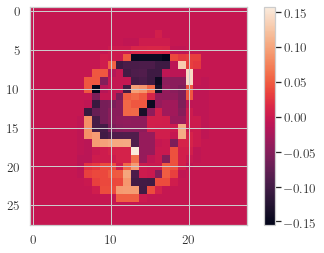

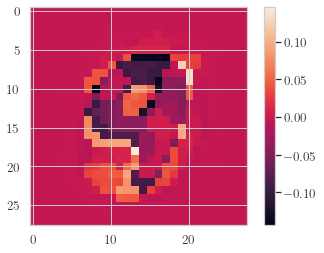

In [125]:
print(weights_timeseries[:,:,25])
plt.imshow(weights_timeseries[:,9,0].reshape(28,28))
plt.colorbar()
plt.show()
plt.imshow(weights_timeseries[:,9,20].reshape(28,28))
plt.colorbar()
plt.show()


NOTES
- may want to look at true binarization (sgn) error instead of tanh version when measuring optimization
- maybe noise should be propto magnitude of gradient? 